**<center><font size=6> Brain Tumor Detection </font></center>**

# <a id='intro'>1. Project Objective</a>

The primary goal of this project is to design, develop, and implement a Convolutional Neural Network (CNN) algorithm capable of accurately detecting brain tumors from magnetic resonance images (MRIs). 

By harnessing the power of deep learning and computer vision techniques, our objective is to create an automated system that aids medical professionals in identifying and localizing brain tumors in a non-invasive and efficient manner.

# <a id='imports'>2. Imports</a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16, preprocess_input
from PIL import Image
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sns
import cv2
import imutils
from tqdm import tqdm

from functools import partial


## <a id='helperfunctions'> 2.1 Helper Functions</a>

In [2]:
def crop_imgs(set_name, target_size=(100, 100), add_pixels_value=0):
    """
    Finds the extreme points on the image, crops the rectangular out of them,
    and resizes the cropped images to the target size.
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, target_size)  # Redimensionar a imagem cortada
        set_new.append(new_img)

    return np.array(set_new)

def load_data(dir_path, img_size=(100, 100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    img = cv2.resize(img, img_size)  # Redimensionar a imagem
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def load_dfs_imgs(data_dir):


    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one dataframe
    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    
    return df


def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()
        
def save_new_images(x_set, y_set, folder_name):
    for i, (img, imclass) in enumerate(zip(x_set, y_set)):
        if imclass == 0:
            save_path = os.path.join(folder_name, 'NO', f'{i}.jpg')
        else:
            save_path = os.path.join(folder_name, 'YES', f'{i}.jpg')
        cv2.imwrite(save_path, img)        

# <a id='loadrawimages'>3. Data Import</a>

In [ ]:
# load all images
path = 'C:/Users/edils/repos/brain_tumor_detection/data/'
img_size = (224,244)

X_train, y_train, labels = load_data(path, img_size)

## <a id='cropimages'>3.1 Crop Images</a>

In [ ]:
# Crop Black parts of each image
X_train_crop = crop_imgs(set_name=X_train)

In [ ]:
plot_samples(X_train_crop, y_train, labels, 20)

## <a id='savecropedimages'>3.2 Save Croped Images</a>

In [ ]:
folder_name = 'C:/Users/edils/repos/brain_tumor_detection/data/cropped/'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

save_new_images(X_train_crop, y_train, folder_name = 'C:/Users/edils/repos/brain_tumor_detection/data/cropped/')

# Load Cropped Images for training

In [3]:
df = load_dfs_imgs(data_dir='C:/Users/edils/repos/brain_tumor_detection/data/cropped/')

In [4]:
df

,filepaths,labels
0,C:/Users/edils/repos/brain_tumor_detection/dat...,NO
1,C:/Users/edils/repos/brain_tumor_detection/dat...,NO
2,C:/Users/edils/repos/brain_tumor_detection/dat...,NO
3,C:/Users/edils/repos/brain_tumor_detection/dat...,NO
4,C:/Users/edils/repos/brain_tumor_detection/dat...,NO
...,...,...
248,C:/Users/edils/repos/brain_tumor_detection/dat...,YES
249,C:/Users/edils/repos/brain_tumor_detection/dat...,YES
250,C:/Users/edils/repos/brain_tumor_detection/dat...,YES
251,C:/Users/edils/repos/brain_tumor_detection/dat...,YES


# Split Train-Val-Test

In [5]:
X_train, X_val = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
X_train, X_test = train_test_split(X_train, test_size=0.1, shuffle=True, random_state=42)

In [6]:
#image size
batch_size=16
img_size = (224,224)
channels=3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

ts_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = tr_gen.flow_from_dataframe(X_train, 
                                       x_col='filepaths', 
                                       y_col='labels',
                                       rescale=1./255,
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

val_gen = tr_gen.flow_from_dataframe(X_val, 
                                       x_col='filepaths', 
                                       y_col='labels',
                                       rescale=1./255,
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

test_gen = tr_gen.flow_from_dataframe(X_test, 
                                       x_col='filepaths', 
                                       y_col='labels',
                                       rescale=1./255,
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=False,
                                       batch_size=batch_size)

Found 181 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

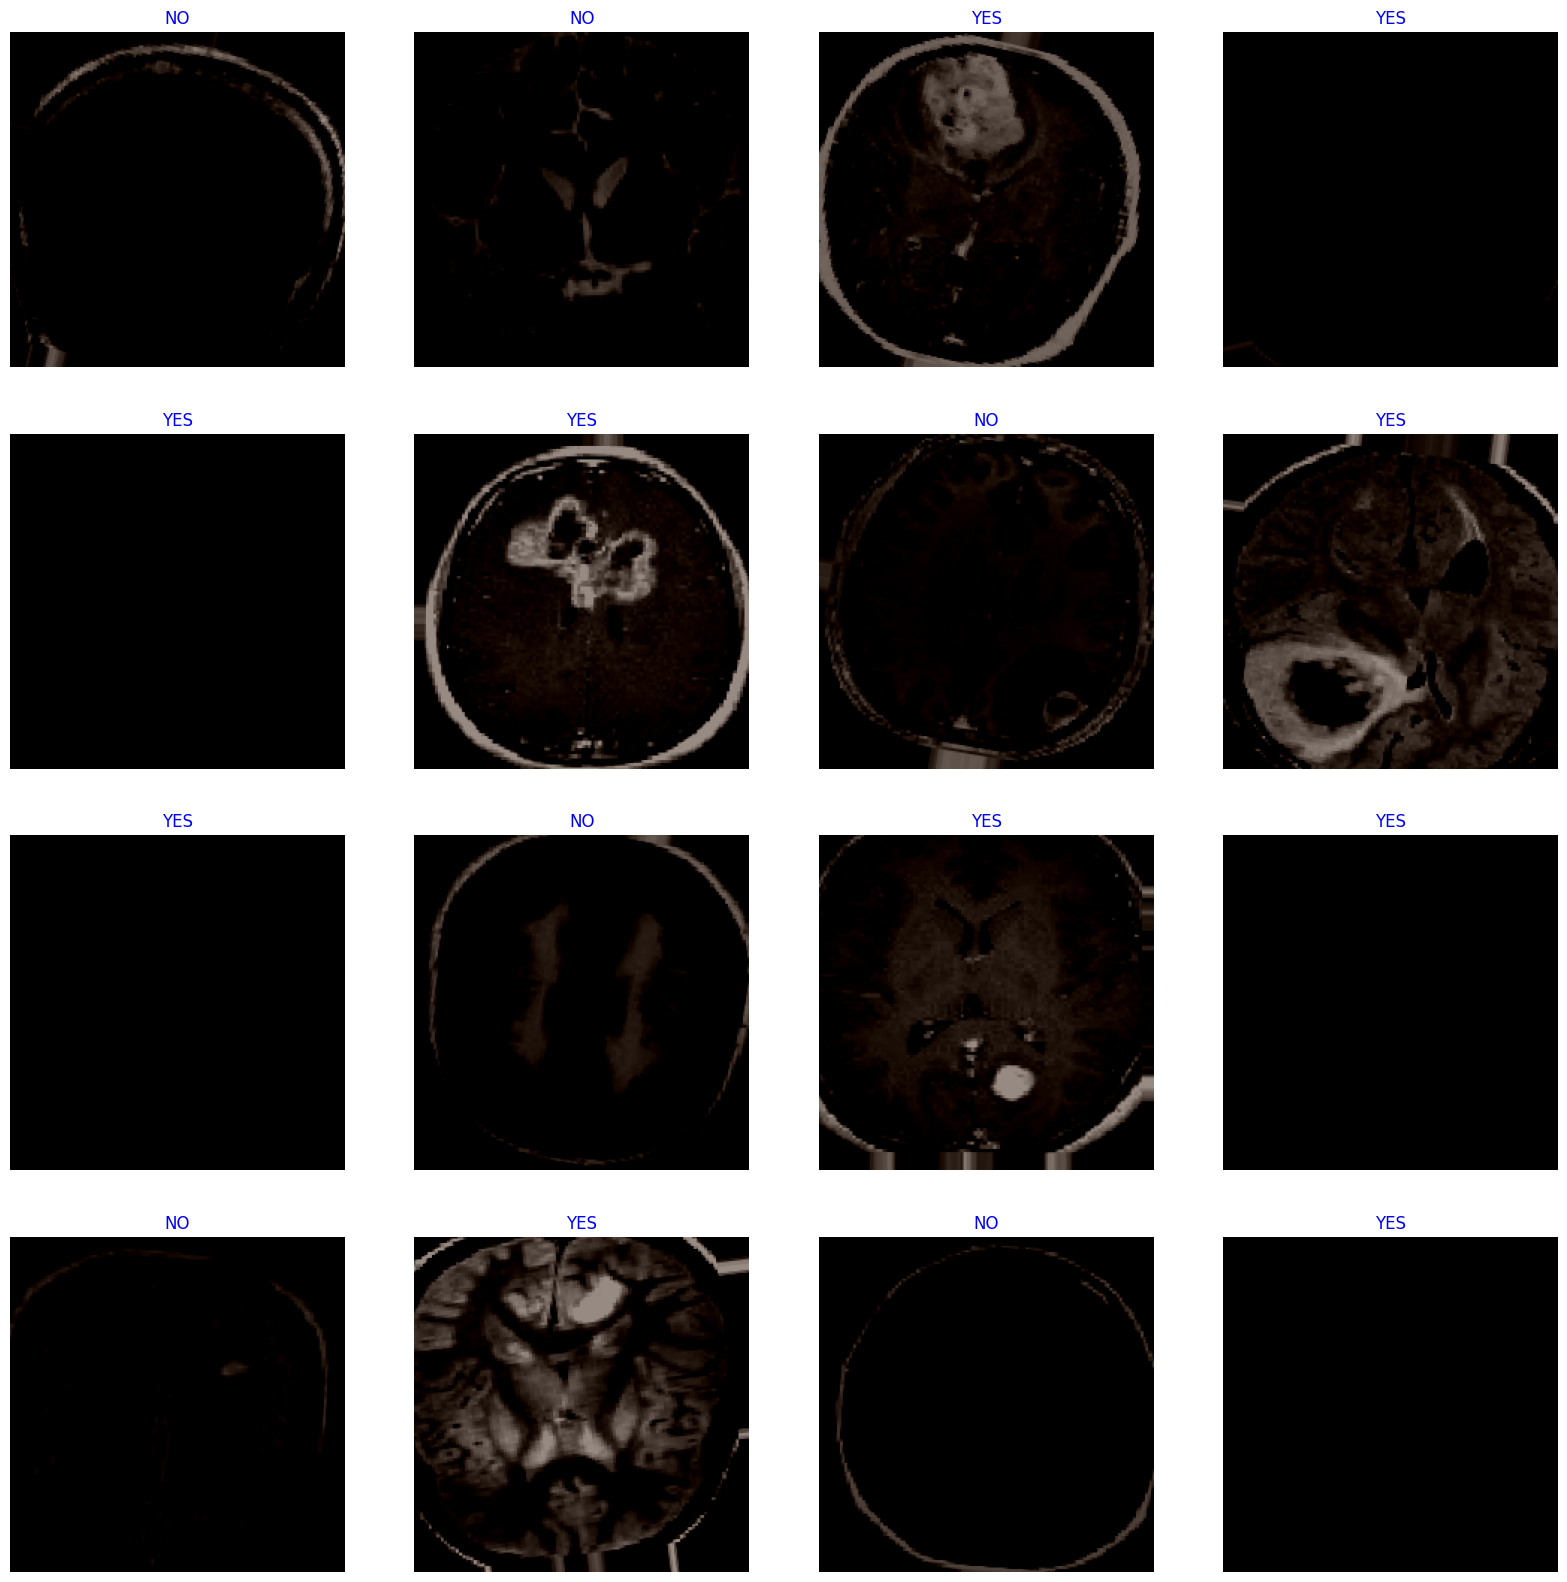

In [7]:
#Show sample data
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [8]:
#VGG 16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [9]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.layers[0].trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14764866 (56.32 MB)
Trainable params: 50178 (196.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [16]:
epochs=30
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[es]
)

Epoch 1/30
12/12 [==============================] - 13s 1s/step - loss: 4.2875 - accuracy: 0.7680 - val_loss: 2.3049 - val_accuracy: 0.8627
Epoch 2/30
12/12 [==============================] - 13s 1s/step - loss: 3.2742 - accuracy: 0.8508 - val_loss: 3.9237 - val_accuracy: 0.8627
Epoch 3/30
12/12 [==============================] - 12s 1s/step - loss: 1.9999 - accuracy: 0.8729 - val_loss: 3.7650 - val_accuracy: 0.8235
Epoch 4/30
12/12 [==============================] - 12s 1s/step - loss: 3.3297 - accuracy: 0.8453 - val_loss: 3.6774 - val_accuracy: 0.8235
Epoch 5/30
12/12 [==============================] - 12s 1s/step - loss: 2.1969 - accuracy: 0.8729 - val_loss: 4.7898 - val_accuracy: 0.8039
Epoch 6/30
12/12 [==============================] - 12s 994ms/step - loss: 3.3775 - accuracy: 0.8453 - val_loss: 5.4744 - val_accuracy: 0.7451
Epoch 7/30
12/12 [==============================] - 12s 1s/step - loss: 2.0562 - accuracy: 0.9116 - val_loss: 5.7824 - val_accuracy: 0.8039


In [12]:
# epochs=30
# batch_size=8
# early_stopping = EarlyStopping(
#                 monitor='val_accuracy', 
#                 mode='max',
#                 patience=5,
#                 restore_best_weights=True
# )


# history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping])

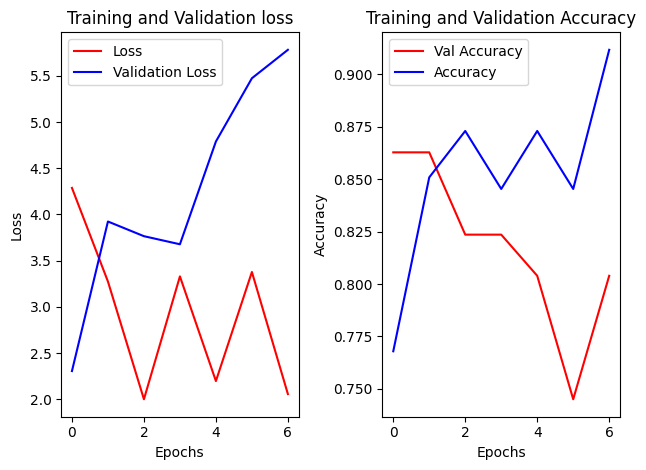

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
acc = history.history['accuracy']

epochs = [*range(7)]



plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, 'r')
plt.plot(epochs, acc, 'b')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Val Accuracy", "Accuracy"])

plt.tight_layout()
plt.show()


In [19]:
model.evaluate(test_gen)

2/2 [==============================] - 1s 257ms/step - loss: 5.5803 - accuracy: 0.8095


[5.5803399085998535, 0.8095238208770752]

In [20]:
y_pred = model.predict(test_gen)

2/2 [==============================] - 1s 260ms/step


In [21]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.labels
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

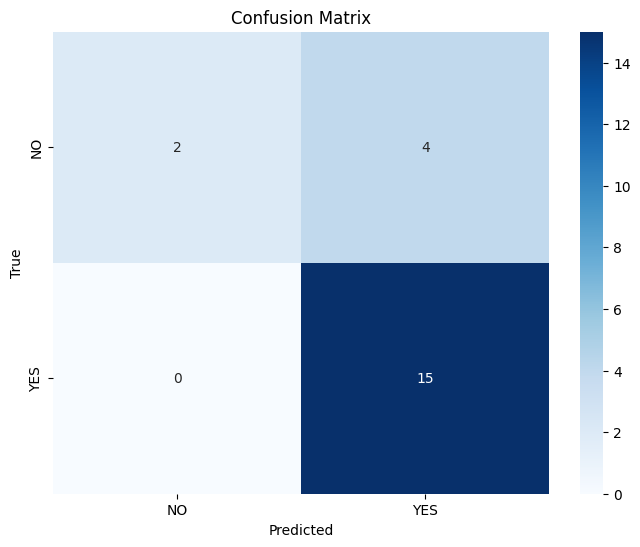

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
recall_score(y_true, y_pred_classes)

In [ ]:
precision_score(y_true, y_pred_classes)